In [1]:

# -*- coding: utf-8 -*-
import os
import pandas as pd
import graphviz
import re

# Phonology sets
h_tone = set("áéíóú")
l_tone = set("àèìòù")
f_tone = set("âêîôû")
r_tone = set("ǎěǐǒǔ")
untoned = set("aeiou")  # For long vowels (â indicates a short vowel with fall tone; âa a long F)
vowels = h_tone | l_tone | r_tone | f_tone | untoned
tones = h_tone | l_tone  # Combine high and low tones
special_tones = r_tone | f_tone  # Special tones (F, R)


tone_bearing_unit = 0 # 0: syllable 1:mora
"""
In this program, the tbu will determin how tones are mapped 
1. if syllables, 

"""
moraic_coda = 1  # 1 if coda carries mora, else 0
word_edge = 1 #1 if there are word boundaries; 0 no boundary



class Autorep:

    def __init__(self, word='', ocp_mel='', assoc=None, boundary=0):
        """
        Initialize an Autorep object.

        Parameters:
        - word (str): The word with tone markers.
        - tone (str): The tone markers directly extracted from the word (HFLR).
        - mel (str): The melody (F -> HL and R -> LH) before OCP.
        - ocp_mel (str): The OCP-applied tone representation of the word.
        - assoc (list): A list of tuples (j, k) indicating the association 
                        between tone (indexed by j), mora (indexed by i), 
                        and syllable (indexed by k).
        """
        self.word = word
        self.tone = ""
        self.mel = ""
        self.ocp_mel = ocp_mel
        self.assoc = self.sort_assoc(assoc if assoc is not None else [])
    
        self.boundary = boundary

        self.tone_labels = {"H": h_tone, "L": l_tone, "F": f_tone, "R": r_tone}
        
        
        if self.word:
            self._process_word()
        
        if self.boundary == 1:
            self.ocp_mel_wb = self._wrap()[0]
            self.boundary = self._wrap()[1]
        
        # self.syl_list = [i + 1 for i in range(self.get_max("s"))]
        # self.syl_moralist = [max((tup[1] for tup in self.assoc if tup[-1] == j), default=0) for j in self.syl_list]
  
         
    def _process_word(self):
        """Process the word to extract tones, assign associations, and apply OCP."""
        syllables = self.word.split(".")
        self.tone = "".join(
            next((k for k, v in self.tone_labels.items() if seg in v), "") 
            for seg in self.word
        )

        if len(syllables) == len(self.tone):
            for i, syl in enumerate(syllables):
                syl_weight = self.check_coda(syl) + self.vowel_count(syl)
                ### if wants do mora bering 
                for j in range(syl_weight):
                    self.assoc.append((self.tone[i], j + 1, i + 1))
                # self.assoc.append((self.tone[i], syl_weight, i + 1))
                
        # else:
        #     print(f"something seems of {self.show()}")
       
        self._flatten_tones(syllables)  # convert F and R into HL and LH
        self.mel = "".join(tone for tone, _, _ in self.assoc)
        self.ocp_mel = re.sub(r"(.)\1+", r"\1", self.mel)
        self._update_tone_indices()
        
        

    def _flatten_tones(self, syllables):
            # print(self.assoc)
            tone_map = {"F": ("H", "L"), "R": ("L", "H")}
            for tone, (t1, t2) in tone_map.items():
                # print(tone, (t1, t2))
                if tone in self.tone:
                    for i, (t, m, s) in enumerate(self.assoc):
                            # print(t, m, s)
                            if t == tone:
                                self.assoc[i] = (t1 if m == 1 else t2, m, s)
        
        
    def _update_tone_indices(self):
        """Update tone indices in association list to match OCP melody."""
        j, i = 0, 0
        while j < len(self.assoc) and i < len(self.ocp_mel):
            if self.assoc[j][0] == self.ocp_mel[i]:
                t, m, s = self.assoc[j]
                self.assoc[j] = (i + 1, m, s)  # Update tone index
                j += 1
            else:
                i += 1
    


    def get_max(self, target):
        """
        self.get_max('t') returns the biggest indexed tone
        self.get_max('s') returns the biggest indexed syllable
        self.get_max('m') returns the total moras
        """
        index_map = {'t': 0, 's': 2}

        if target in index_map:
            return max(
                (item[index_map[target]] for item in self.assoc if item[index_map[target]] is not None), 
                default=0
            )
        elif target == 'm':
            return sum(self.syl_mora_list())  # Return the sum of self.moralist if target is 'm'

        return 0  # Return 0 for invalid target
    
    @staticmethod
    def check_coda(syl):
        """Check if a syllable contains a coda."""
        for i in range(1, len(syl)):
            if syl[i] not in vowels and syl[i - 1] in vowels:
                return moraic_coda
        return 0

    @staticmethod
    def vowel_count(syl):
        """Count the number of vowels and adjust for special tones."""
        count = 0
        for i, char in enumerate(syl):
            if char in vowels or char in tones:
                count += 1
            elif (
                char in special_tones
                and i + 1 < len(syl)
                and syl[i + 1] not in vowels
            ):
                count += 2
        return count

    @staticmethod
    def mora_count(string):
        """Count the number of mora in a string."""
        mora_count = 0
        mora_list = []
        syllables = string.split(".")
        for syl in syllables:
            syl_weight = Autorep.check_coda(syl) + Autorep.vowel_count(syl)
            mora_list.append(syl_weight)
            mora_count += syl_weight
        return mora_count, mora_list                                
    
    @staticmethod
    def contour_count(s):
        """Count the number of contour tones in a string."""
        return sum(1 for char in s if char in special_tones)

    @staticmethod
    def index_reset(lst):   

        """Reset indices of the association list to start from 1."""
        if not lst:
            return []
        
        else:
            t_shift = min((t for (t, _, _) in lst if t is not None), default=0)
            
            s_shift = min((s for( _, _, s) in lst if s is not None), default=0)
            # m_shift = min((m for _,m,s in lst if s == s_shift), default= 0)

            return [
                (
                    (t - t_shift + 1) if t else None,
                    m,
                    (s - s_shift + 1) if s else None,
                )
                for (t, m, s) in lst
            ]

    @staticmethod
    def sort_assoc(assoc):
        def custom_compare(x):
            return float('inf') if x is None else x

        sorted_assoc = sorted(
            assoc,
            key=lambda x: (
                custom_compare(x[0]),
                custom_compare(x[2]),
                custom_compare(x[1])
            )
        )
        return sorted_assoc

        
    def check_empty(self):
        """Check if the object is empty."""
        return not (self.word or self.assoc or self.mel or self.ocp_mel)
    
    
    @staticmethod
    def is_modified_substring(list_a, list_b):
        if list_a == list_b:
            return True

        n, m = len(list_a), len(list_b)

        for i in range(m - n + 1):
            window = list_b[i:i+n]
            
            # Skip if list_a[-1] > window[-1]
            if list_a[-1] > window[-1]:
                continue

            # Check middle elements
            middle_match = True
            for a, b in zip(list_a[1:-1], window[1:-1]):
                if a != 0 and a != b:
                    middle_match = False
                    break

            if middle_match:
                return True

        return False


    
    def check_contain(container, containee):
                
        if not containee.syl_mora_list():
            # print(f"no moralist and meldoy {containee.ocp_mel_wb} in {container.ocp_mel_wb} match: {containee.ocp_mel_wb in container.ocp_mel_wb}")
            return containee.ocp_mel in container.ocp_mel  # If no syllables, check melody
        
        if not containee.ocp_mel:
            return containee.is_modified_substring(containee.syl_mora_list(),container.syl_mora_list()) #and containee.ocp_mel_wb in container.ocp_mel_wb
        
        conditions = [
            (container.check_empty(), "container is empty"),
            (containee.syl_mora_list() and not container.syl_mora_list(), "containee.moralist exists, but container.moralist is missing."),
            (containee.ocp_mel and not container.ocp_mel, "containee.ocp_mel exists, but container.ocp_mel is missing."),
           # (not containee.boundary.issubset(container.boundary), 
            #    f"containee.boundary ({containee.boundary}) is not a subset of container.boundary ({container.boundary})."),
            (containee.count_full_tuples() > container.count_full_tuples(), 
                f"containee.count_full_tuples() ({containee.count_full_tuples()}) > container.count_full_tuples() ({container.count_full_tuples()})."),
            (containee.get_max('t') > container.get_max('t'), 
                f"containee.get_max('t') ({containee.get_max('t')}) > container.get_max('t') ({container.get_max('t')})."),
            (containee.get_max('s') > container.get_max('s'), 
                f"containee.get_max('s') ({containee.get_max('s')}) > container.get_max('s') ({container.get_max('s')})."),
            (containee.get_max('m') > container.get_max('m'), 
                f"containee.get_max('m') ({containee.get_max('m')}) > container.get_max('m') ({container.get_max('m')})."),
            (containee.ocp_mel not in container.ocp_mel, f"{container} more association")
        ]

        # Check which conditions failed and print debug messages
        failed_conditions = [msg for cond, msg in conditions if cond]

        if failed_conditions:
            # for msg in failed_conditions:
            #     print(f"❌ Debug: {msg}")
            return False

        if containee == container:
            return True
        
        if containee.check_empty():
            return True  # `containee` is empty → always contained
    
        if containee.count_full_tuples()==0:
            # print('no fully connected pair')
            return containee.is_modified_substring(containee.syl_mora_list(),container.syl_mora_list()) #and containee.ocp_mel_wb in container.ocp_mel_wb
        
        
        
        match_positions = [m.start() for m in re.finditer(f"(?={re.escape(containee.ocp_mel)})", container.ocp_mel)]

        if match_positions and container.boundary == 0:
            # print(match_positions)
            for match_pos in match_positions:
                match = True
                # print(match_pos)
                ## taking a restriction out of larger ar
                tone_idx_spanning_container = range(match_pos+1,match_pos+containee.get_max('t')+1)
                # print("tone idx spanning",tone_idx_spanning_container)
                syl_start_idx_container = min(
                    (tup[2] for tup in container.assoc if tup[0] == match_pos + 1 and tup[2] is not None),
                    default=0
                ) 
               
               
                syl_idx_spanning_container = range(syl_start_idx_container,syl_start_idx_container+containee.get_max('s'))
                # print("syl spanning",syl_idx_spanning_container)
                restriction_assoc = [tup for tup in container.assoc if
                                    (tup [0] in tone_idx_spanning_container) or (tup[2] in syl_idx_spanning_container)]

                restriction_assoc = [
                                    tup for tup in restriction_assoc 
                                    if tup[0] is None or tup[0] >= match_pos + 1
                                    ]
                # print(restriction_assoc)
                
                restriction_ar = Autorep("",containee.ocp_mel, containee.index_reset(restriction_assoc))
                
                
                    
                # print('restriction',restriction_ar)
                
                scan_window = len(containee.assoc)
                
                if scan_window <= len(container.assoc):
                                
                    for i in range(len(restriction_ar.assoc) - scan_window + 1):
                        candidate_slice = restriction_ar.index_reset(restriction_ar.assoc[i:i+scan_window])
                        # print(i,candidate_slice)


                        # Direct match
                        if containee.assoc == candidate_slice:

                            return True

                        # Flexible matching (with None and inequality allowance)
                
                        match = True
                        for (t1, m1, s1), (t2, m2, s2) in zip(containee.assoc, candidate_slice):
                            # print(f"{(t1, m1, s1)} vs {(t2, m2, s2)}")

                            # Tone match
                            if t1 is None:
                                tone_match = True
                            elif t2 is None:
                                tone_match = False
                            else:
                                tone_match = t1 == t2

                            # Mora match
                            if m1 is None:
                                mora_match = True
                            elif m2 is None:
                                mora_match = False
                            else:
                                mora_match = (m1 <= m2)

                            # Syllable match
                            if s1 is None:
                                syl_match = True
                            elif s2 is None:
                                syl_match = False
                            else:
                                syl_match = s1 == s2

                            if not (tone_match and mora_match and syl_match):
                                match = False
                                
                        
                        if match == True:
                            # double_check = False
                            # print("match >> double check")
                            # print(f"tone_mora_list-syl list for containee {containee.tone_mora_list()}")
                            # print(f"tone_mora_list-syl list for container {restriction_ar.tone_mora_list()}")
                            # print(f"partial match? {containee.is_modified_substring(containee.tone_mora_list(), restriction_ar.tone_mora_list())}")
                            # print(f"mora_tone_list for containee {containee.mora_tone_list()}")
                            # print(f"mora_tone_list for container {restriction_ar.mora_tone_list()}")
                            # print(f"partial match? {containee.is_modified_substring(containee.mora_tone_list(), restriction_ar.mora_tone_list())}")
                            if containee.is_modified_substring(containee.tone_mora_list(), restriction_ar.tone_mora_list()):
                  
                                if containee.is_modified_substring(containee.mora_tone_list(), restriction_ar.mora_tone_list()):
                            
                                    return True
                                else:
                                    print(f"seems wrong check1 {containee, container}")  

                            

                elif scan_window > len(container.assoc):
                        double_check = False
                        # print("match >> double check")
                        # print(f"tone_mora_list-syl list for containee {containee.tone_mora_list()}")
                        # print(f"tone_mora_list-syl list for container {restriction_ar.tone_mora_list()}")
                        # print(f"partial match? {containee.is_modified_substring(containee.tone_mora_list(), restriction_ar.tone_mora_list())}")
                        # print(f"mora_tone_list for containee {containee.mora_tone_list()}")
                        # print(f"mora_tone_list for container {restriction_ar.mora_tone_list()}")
                        # print(f"partial match? {containee.is_modified_substring(containee.mora_tone_list(), restriction_ar.mora_tone_list())}")
                        if containee.is_modified_substring(containee.tone_mora_list(), restriction_ar.tone_mora_list()):
                            if containee.is_modified_substring(containee.mora_tone_list(), restriction_ar.mora_tone_list()):
                                return True
                            else:
                                print(f"seems wrong check2 {containee, container}")            
                else:
                    print(f"seems wrong check3 {containee, container}")
                    return False



        return False
     
        
    
                        

    
    def add_tone(self):
        """
        Add an unassociated tone in the AR by updating the melody and the association list.
        
        - A new tone ('H' or 'L') is added to the melody.
        - A new association (j, None, None) is added, where:
            - j is one-unit higher than the previous tone's number or 1 if starting fresh.
            - 'None' indicates the syllable is not associated with any tone unit.
        """
        # Copy the existing associations to avoid modifying the original
       
        new_assoc = self.assoc.copy()
        # Determine the next tone to add
        if not self.ocp_mel:  # Empty string case
            return [Autorep(ocp_mel='H', assoc=new_assoc + [(1, None, None)]),
                    Autorep(ocp_mel='L', assoc=new_assoc + [(1, None, None)])]
        
        else:
            # print('adding a tone')
            next_tone = 'H' if self.ocp_mel[-1] == 'L' else 'L'
            next_tone_index = self.get_max('t') + 1
            
            # Create the updated autorep
            return [Autorep(
                ocp_mel=self.ocp_mel + next_tone,
                assoc=new_assoc + [(next_tone_index, None, None)]
            )]
        
    
    
    def add_syl(self):
        new_assoc = self.assoc.copy()
        next_syl_index = self.get_max('s') + 1 if self.get_max('s') else 1
        new_assoc.append((None, 1, next_syl_index))
        new_ar = Autorep(ocp_mel= self.ocp_mel,assoc = new_assoc)
        return new_ar

    def add_weight(self, weight):
        new_assoc = self.assoc.copy()
        mora_list = self.syl_mora_list()
        
        if self.get_max('s') > 0 and mora_list[-1] < weight and mora_list[-1] >= 1:
            current_weight = mora_list[-1]
            new_weight = current_weight + 1

            # Find the last association with the highest syllable index
            # In other words, only the rightmost syllable can add weight
            max_s = self.get_max('s')
            for idx in reversed(range(len(new_assoc))):
                t, m, s = new_assoc[idx]
                if s == max_s:
                    # Add a new tuple with the same tone and syllable, but increased mora weight
                    new_assoc.insert(idx + 1, (None, new_weight, s))
                    break

            new_ar = Autorep(ocp_mel=self.ocp_mel, assoc=new_assoc)
            return new_ar


    def add_assoc(self):
        # Gather floating elements and valid connected triples
        floating_tone = min((t for t, m, s in self.assoc if not s), default=None)
        floating_syl = min((s for t, m, s in self.assoc if not t), default=None)
        floating_syl_min_weight = min(
            (m for t, m, s in self.assoc if not t and s == floating_syl), default=None
        )
        valid_connected = [(t, m, s) for t, m, s in self.assoc if t and m and s]

        if floating_tone is None and floating_syl is None:
            return None

        possible_assoc = []

        # Case 1: Floating tone connects to valid syllable
        if floating_tone and valid_connected:
            max_valid_syl = max(s for t, m, s in valid_connected)
            valid_syl_weight = max(m for t, m, s in valid_connected if s == max_valid_syl)

            updated = [
                (t, valid_syl_weight, max_valid_syl) if t == floating_tone else (t, m, s)
                for t, m, s in self.assoc
            ]
            possible_assoc.append(updated)
            # print("float tone to connected syl", updated)

        # Case 2: Floating syllable connects to valid tone
        if floating_syl and valid_connected:
            max_valid_tone = max(t for t, m, s in valid_connected)

            updated = [
                (max_valid_tone, m, s) if s == floating_syl and m == floating_syl_min_weight else (t, m, s)
                for t, m, s in self.assoc
            ]
            possible_assoc.append(updated)
            # print("floating_syl_to_valid_tone", updated)

        # Case 3: Floating tone connects directly to floating syllable
        if floating_tone and floating_syl:
            new_assoc = [
                (floating_tone, m, s)
                if s == floating_syl and m == floating_syl_min_weight else
                (t, m, s)
                for t, m, s in self.assoc
                if not (t == floating_tone and m is None and s is None)  # remove float tone tuple
            ]
            possible_assoc.append(new_assoc)
            # print("float syl to float tone", new_assoc)

        return possible_assoc


    
    def next_ar(self,max_syl_weight):

        next_ar = [self.add_syl()]
        next_ar.extend(self.add_tone())
        
        if self.add_weight(max_syl_weight):
             next_ar.append(self.add_weight(max_syl_weight))
             
        if self.add_assoc():
    # print("adding new assoc")
            for i in self.add_assoc():
                next_ar.append(Autorep('',self.ocp_mel, i))
                
        return next_ar


    def info(self):
        return Autorep(ocp_mel = self.ocp_mel, assoc = self.assoc)

    def show(self):
        print(self.ocp_mel,self.assoc) 

    def fully_spec(self):
        return all(t is not None and m is not None and s is not None for t, m, s in self.assoc)

    def __eq__(self, other):
        if not isinstance(other, Autorep):
            return NotImplemented
        return self.ocp_mel == other.ocp_mel and self.assoc == other.assoc


    def __hash__(self):
        return hash((tuple(self.assoc), self.word))

        
       
    def t_factor(self):
        tone_num = len(self.ocp_mel)
        return tone_num
    
    def s_factor(self):
        syl_num = max([k for _,_,k in self.assoc if k is not None], default=0)
        return syl_num     

    def k_factor(self):
        return self.t_factor() + self.s_factor()
    
    def __repr__(self):
        return f"{self.ocp_mel}, {self.assoc}"
    
    def draw(self, name="",output = False):

        drawing = self.assoc[:]

        for i, tup in enumerate(self.assoc, start=1):
            if tup[1] is not None or tup[2] is not None:
                drawing[i - 1] = (tup[0], i, tup[2])

        if not name:
            file_path = os.path.join("new_cons/", f"{self.word}" if self.word else f"{self.ocp_mel}")
        else:
            file_path = os.path.join("new_cons/", f"{name}")

        d = graphviz.Digraph(filename=file_path, format='png')
        
        # Global layout tuning
        d.attr(nodesep="0.01", ranksep="0.05", margin="0", fontsize="10")

        # Melody nodes
        with d.subgraph() as s1:
            s1.attr(rank='source', rankdir='LR')
            for i, t in enumerate(self.ocp_mel):
                s1.node(f'Mel_{i+1}', label=t, shape='plaintext', fontsize="10", width="0", height="0")

        if not self.syl_mora_list():
            return s1

        # Add σ nodes and edges
        for t, m, s in self.assoc:
            if m:
                label = 'σ'
                if m == 1:
                    label = '<σ<sub>μ</sub>>'
                elif m == 2:
                    label = '<σ<sub>μμ</sub>>'
                elif m >= 3:
                    label = '<σ<sub>μμμ</sub>>'
                d.node(f'Syl_{s}', label=label, shape='plaintext', fontsize="10", width="0", height="0")
            if t and s:
                d.edge(f'Mel_{t}', f'Syl_{s}', dir='none', arrowsize="0.5", penwidth="0.5")
        if output == False:
            return display(d)
        else:
            d.render(cleanup=True)  # Save the image file
            return file_path + ".png"
            #

    def count_full_tuples(autorep_obj):
        """
        Counts the number of tuples in autorep_obj where all three positions are non-None.
        
        :param autorep_obj: An instance of Autorep with a list of tuples.
        :return: The count of tuples with all three values present.
        """
        return sum(1 for tup in autorep_obj.assoc if all(val is not None for val in tup))


    def tone_syl_list(self):
        tone_syl_list = []
        prev_max = 0  # Store max(tup[2]) of previous tone index
        
        if self.ocp_mel:
            for i in range(self.get_max('t')):  # Loop through tone indices
                # Extract `tup[2]` values where `tup[0] == i+1` and `tup[2] is not None`
                syl_values = [tup[2] for tup in self.assoc if tup[0] == i + 1 and tup[2] is not None]
                
                # Compute max(tup[2]) for current tone index
                current_max = max(syl_values) if syl_values else prev_max  
                
                # Compute span: difference from previous max
                i_tone_syl = current_max - prev_max if current_max!= prev_max else 1
                tone_syl_list.append(i_tone_syl)
                
                # Update prev_max for next iteration
                prev_max = current_max  
        
        return tone_syl_list
        
    def syl_tone_list(self):
        syl_tone_list = []
        max_s = self.get_max('s')
        
        for s in range(1, max_s + 1):  # 1-indexed syllables
            tone_count = set(tup[0] for tup in self.assoc if tup[2] == s and tup[0] is not None)
            syl_tone_list.append(len(tone_count))
            # print(f"→ Syllable {s} has {tone_count} tone(s)")
        
        # print(f"✅ syl_tone_list: {syl_tone_list}")
        return syl_tone_list

    
    def syl_mora_list(self):
        syl_mora_list = []
        if self.get_max('s') > 0:
            for i in range(self.get_max('s')):
                mora_values = len(set([tup[1] for tup in self.assoc if tup[2] == i+1 and tup[1] is not None]))
                syl_mora_list.append(mora_values)
        return syl_mora_list

    def nested_mora_tone_list(self):
        max_s = self.get_max('s')
        nested_mora_tone_list = []

        for s in range(1, max_s + 1):  # 1-indexed syllables
            # Get max mora in this syllable (0 if none)
            moras = max(
                [tup[1] if tup[1] is not None else 0 for tup in self.assoc if tup[-1] == s],
                default=0
            )
            # print(f'→ Syllable {s} has {moras} mora(s)')

            syllable_list = []
            for mora in range(1, moras + 1):  # 1-indexed moras
                tone_count = 0
                for tone, mora_idx, syll_idx in self.assoc:
                    if syll_idx == s and mora_idx == mora and tone is not None:
                        tone_count += 1
                # print(f'   Mora {mora} in syll {s} has {tone_count} tone(s)')
                syllable_list.append(tone_count)

            nested_mora_tone_list.append(syllable_list)

        # print(f'Final nested mora_tone_list: {nested_mora_tone_list}')
        return nested_mora_tone_list
    
    def mora_tone_list(self):
        max_s = self.get_max('s')
        mora_tone_list = []

        for s in range(1, max_s + 1):  # Syllables assumed to be 1-indexed
            # Get the maximum mora index for syllable `s` (0 if all are None)
            moras = max(
                [tup[1] if tup[1] is not None else 0 for tup in self.assoc if tup[-1] == s],
                default=0
            )
            # print(f'Syllable {s} has {moras} mora(s)')

            for mora in range(1, moras + 1):  # Moras also assumed to be 1-indexed
                tone_count = 0
                for tup in self.assoc:
                    tone, mora_idx, syllable_idx = tup
                    if syllable_idx == s and mora_idx == mora and tone is not None:
                        tone_count += 1

                # print(f'  → Mora {mora} in syllable {s} has {tone_count} tone(s)')
                mora_tone_list.append(tone_count)

        # print(f'Final mora_tone_list: {mora_tone_list}')
        return mora_tone_list


    
    def tone_mora_list(self):
        result = []
        max_t = self.get_max('t')
        for t in range(1, max_t + 1):  # Assuming syllable indexing starts from 1
            mora = set()
            moras = set(tup for tup in self.assoc if tup[0] == t and tup[1] is not None)
            result.append(len(moras))
        return result

                

In [5]:
import pprint
def convert_to_ar(filename):
    """
    Convert a text file to a list of distinct Autorep objects.
    """
    autorep_list = []
    try:
        with open(filename, "r") as file:
            for line in file:
                asr = Autorep(line.strip())
                autorep_list.append(asr)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []

    autoset = set()
    unique_autoreps = []

    for i in autorep_list:
        info = i.info()
        if info not in autoset:
            pprint.pprint(i)
            unique_autoreps.append(i)
            autoset.add(info)
        # else:
        #     print(f"Duplicate found: {i.word}")

    print(f'Processed {len(autorep_list)} words, found {len(unique_autoreps)} unique ASRs in {filename}')
    return unique_autoreps
autolist = convert_to_ar("/Users/lihan/github/AR_learning/hausa_syllabfied.txt")

H, [(1, 1, 1), (1, 1, 2), (1, 2, 2)]
LH, [(1, 1, 1), (1, 2, 1), (2, 1, 2), (2, 2, 2)]
LH, [(1, 1, 1), (2, 1, 2), (2, 2, 2)]
HL, [(1, 1, 1), (2, 1, 2), (2, 2, 2)]
HL, [(1, 1, 1), (1, 2, 1), (2, 1, 2), (2, 2, 2)]
H, [(1, 1, 1), (1, 2, 1), (1, 1, 2), (1, 2, 2)]
LHL, [(1, 1, 1), (1, 2, 1), (2, 1, 2), (3, 1, 3), (3, 2, 3)]
LHL, [(1, 1, 1), (2, 1, 2), (3, 1, 3), (3, 2, 3)]
LH, [(1, 1, 1), (1, 2, 1), (1, 1, 2), (1, 2, 2), (2, 1, 3), (2, 2, 3)]
HL, [(1, 1, 1), (1, 1, 2), (2, 1, 3), (2, 2, 3)]
LH, [(1, 1, 1), (1, 2, 1), (1, 1, 2), (1, 1, 3), (1, 2, 3), (2, 1, 4), (2, 2, 4)]
LH, [(1, 1, 1), (1, 2, 1), (2, 1, 2), (2, 1, 3), (2, 2, 3)]
HLH, [(1, 1, 1), (2, 1, 2), (3, 1, 3), (3, 2, 3)]
LHL, [(1, 1, 1), (2, 1, 2), (3, 2, 2)]
L, [(1, 1, 1), (1, 1, 2)]
HL, [(1, 1, 1), (1, 2, 1), (1, 1, 2), (1, 2, 2), (2, 1, 3), (2, 2, 3)]
LH, [(1, 1, 1), (2, 1, 2), (2, 2, 2), (2, 1, 3), (2, 2, 3)]
H, [(1, 1, 1), (1, 2, 1)]
LHL, [(1, 1, 1), (2, 1, 2), (2, 2, 2), (3, 1, 3), (3, 2, 3)]
HLH, [(1, 1, 1), (2, 1, 2), (2, 2, 

seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], LHL, [(1, 1, 1), (2, 1, 2), (3, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLHL, [(1, 1, 1), (2, 2, 1), (3, 1, 2), (3, 2, 2), (4, 1, 3), (4, 2, 3)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLH, [(1, 1, 1), (2, 2, 1), (3, 1, 2), (3, 2, 2)])
HL, [(1, 1, 1), (2, 1, 1)]


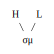

seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], LHL, [(1, 1, 1), (2, 1, 2), (3, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLHL, [(1, 1, 1), (2, 2, 1), (3, 1, 2), (3, 2, 2), (4, 1, 3), (4, 2, 3)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLH, [(1, 1, 1), (2, 2, 1), (3, 1, 2), (3, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1)])
LH, [(1, 1, 1), (2, 1, 1)]


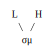

seems wrong check1 (LH, [(1, 1, 1), (2, 1, 1)], LH, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (LH, [(1, 1, 1), (2, 1, 1)], LH, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (LH, [(1, 1, 1), (2, 1, 1)], LH, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (LH, [(1, 1, 1), (2, 1, 1)], LH, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (LH, [(1, 1, 1), (2, 1, 1)], LH, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (LH, [(1, 1, 1), (2, 1, 1)], LH, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], LHL, [(1, 1, 1), (2, 1, 2), (3, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLHL, [(1, 1, 1), (2, 2, 1), (3, 1, 2), (3, 2, 2), (4, 1, 3), (4, 2, 3)])
seems wrong check1 (HL, [(1, 1

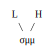

seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLH, [(1, 1, 1), (2, 2, 1), (3, None, None)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2)])
seems 

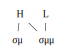

seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2), (None, 2, 2), (None, 1, 3)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLH, [(1, 1, 1), (2, 2, 1), (3, None, None), (None, 1, 2), (None, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (2, 1, 2), (None, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2), (None, 2, 2), (None, 1, 3)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLH, [(1, 1, 1), (2, 2, 1), (3, None, None), (None, 1, 2), (None, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (2, 1, 2), (None, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2), (None, 2, 2), (None, 1, 3)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLH, [(1, 1, 1), (2, 2, 1), (3, None, None), (None, 1, 2), (None, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (2,

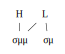

seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2), (None, 2, 2), (None, 1, 3)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLH, [(1, 1, 1), (2, 2, 1), (3, None, None), (None, 1, 2), (None, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (2, 1, 2), (None, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2), (None, 2, 2), (None, 1, 3)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLH, [(1, 1, 1), (2, 2, 1), (3, None, None), (None, 1, 2), (None, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (2, 1, 2), (None, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (None, 1, 2), (None, 2, 2), (None, 1, 3)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HLH, [(1, 1, 1), (2, 2, 1), (3, None, None), (None, 1, 2), (None, 2, 2)])
seems wrong check1 (HL, [(1, 1, 1), (2, 1, 1)], HL, [(1, 1, 1), (2, 2, 1), (2,

{, [(None, 1, 1), (None, 2, 1), (None, 3, 1)],
 HL, [(1, 1, 1), (1, 1, 2), (2, 2, 2)],
 HL, [(1, 1, 1), (2, 1, 1)],
 HL, [(1, 1, 1), (2, 2, 1), (2, 1, 2)],
 LH, [(1, 1, 1), (2, 1, 1)],
 LH, [(1, 1, 1), (2, 2, 1)]}

In [6]:
from queue import Queue

def check_from_data(ar, positive_data, find=False):
    """Check if an Autorep object `ar` is a substructure of any in `positive_data`."""
    for i in positive_data:
        if i.check_contain(ar):
            if find:
                print(i.word,i)
            return True
    return False


def not_contain_forbidden_piece(ar, grammar):
    """Check that `ar` does NOT contain any structure from the `grammar` set."""
    for i in grammar:
        if ar.check_contain(i):
            return False
    return True


def Get_Max_weight(D):
    """Determine the max syllable weight allowed, and provide base forbidden structures."""
    sp = Autorep("", "", [(None, 1, 1),(None, 2, 1),(None, 3, 1)])
    heavy = Autorep("", "", [(None, 1, 1),(None, 2, 1)])

    if check_from_data(sp, D):
        return 3, None
    elif check_from_data(heavy, D):
        return 2, {sp}
    else:
        return 1, {sp, heavy}


def bufia(D, t=2, s=2, m=4):
    """
    Breadth-first grammar induction algorithm from positive data D,
    with complexity thresholds t, s, m.
    """
    t_threshold = t
    s_threshold = s
    max_syl_weight, initial_grammar = Get_Max_weight(D)
    G = initial_grammar if initial_grammar else set()

    Q = Queue()
    V = set()
    s0 = Autorep()  # Empty starting structure
    Q.put(s0)

    # Optional: logging to HTML (currently commented out)
    # with open("generated_results_new.html", "w") as outfile:
    #     outfile.write("<html><head><title>Generated Results</title></head><body>\n")
    #     outfile.write("<h1>Generated Constraints</h1>\n")
    #     counter = 0

    while not Q.empty():
        s = Q.get()
        V.add(s)

        if check_from_data(s, D):  # Structure fits data
            S = s.next_ar(max_syl_weight)
            for i in S:
                if (
                    i in V
                    or not not_contain_forbidden_piece(i, G)
                    or i.get_max('t') > t_threshold
                    or i.get_max('s') > s_threshold
                    or i.get_max('m') > m
                ):
                    continue
                Q.put(i)

        else:
            if s not in G and not_contain_forbidden_piece(s, G):
                G.add(s)
                print(s)
                s.draw()
                # Optional: log constraint image to HTML
                # counter += 1
                # image_path = s.draw(f"cons{counter}", True)
                # outfile.write(f"<h2>Constraint {counter}:</h2>\n")
                # outfile.write(f"<p>{s.info()}</p>\n")
                # outfile.write(f"<img src='{image_path}' alt='cons{counter}'>\n")
                # outfile.write("<hr>\n")

    # outfile.write("</body></html>\n")
    print(f'Found {len(G)} constraints')
    return G


# Run the function
bufia(autolist,2,2,4)


In [7]:
# ============================
# Creating Autorep Objects
# ============================
a = Autorep("dú.hùu")  
b = Autorep("fà.dá.màa")  
c = Autorep("gáa.jì.màa.rée") 

# ============================
# Basic Containment Tests
# ============================
print(f"[1] gáa.jì.màa.rée contains dú.hùu:           {c.check_contain(a)}  # Expect False")
print(f"[2] gáa.jì.màa.rée contains fà.dá.màa:         {c.check_contain(b)}  # Expect False")
print(f"[3] fà.dá.màa contains dú.hùu:                 {b.check_contain(a)}  # Expect True")
print(f"[4] fà.dá.màa contains gáa.jì.màa.rée:         {b.check_contain(c)}  # Expect False")
print(f"[5] dú.hùu contains fà.dá.màa:                 {a.check_contain(b)}  # Expect False")
print(f"[6] dú.hùu contains gáa.jì.màa.rée:            {a.check_contain(c)}  # Expect False")

# ============================
# Floating Tone/Syllable Tests
# ============================
float_rising = Autorep(ocp_mel="LH", assoc=[(1, None, None), (2, None, None)])
rising = Autorep(ocp_mel="LH", assoc=[(2, 2, 1), (1, 1, 1)])
print(f"[7] Rising contains float_rising:              {rising.check_contain(float_rising)}  # Expect True")

heavy = Autorep(assoc=[(None, 1, 1), (None, 2, 1)])
superheavy = Autorep("", "", [(None, 1, 1), (None, 2, 1), (None, 3, 1)])
print(f"[8] Superheavy contains heavy:                 {superheavy.check_contain(heavy)}  # Expect True")

rising = Autorep(ocp_mel="LH", assoc=[(1, 1, 1), (2, 2, 1)])
fall = Autorep(ocp_mel="HL", assoc=[(1, 1, 1), (2, 2, 1)])

print(f"[9] Rising contains heavy:                     {rising.check_contain(heavy)}  # Expect True")

floatH = Autorep("", "H", assoc=[(1, None, None)])
print(f"[10] Fall contains float H:                    {fall.check_contain(floatH)}")

floatH_mono = Autorep(ocp_mel="H", assoc=[(1, None, None), (None, 1, 1)])
print(f"[11] Fall contains monosyllabic float H:       {fall.check_contain(floatH_mono)}")

# ============================
# More Complex Wrong Cases
# ============================
wrong1 = Autorep("", "LH", [(1, 1, 1), (None, 2, 1), (2, None, None), (None, 1, 2), (None, 1, 3)])
wrong2 = Autorep("", "LH", [(1, 1, 1), (2, None, None)])
print(f"[12] wrong1 contains wrong2:                   {wrong1.check_contain(wrong2)}  # Expect True")

wrong3 = Autorep("", "HL", [(1, 1, 1), (1, 2, 1), (2, 1, 2), (2, 1, 3)])
wrong2 = Autorep("", "HL", [(1, 1, 1), (2, 1, 2), (2, 1, 3)])
print(f"[13] wrong3 contains wrong2:                   {wrong3.check_contain(wrong2)}  # Expect True")

wrong4 = Autorep("", "LH", [(1, None, None), (None, 1, 1), (2, None, None)])
wrong5 = Autorep("", "LH", [(1, 1, 1), (2, None, None)])
print(f"[14] wrong5 contains wrong4:                   {wrong5.check_contain(wrong4)}  # Expect True")

wrong6 = Autorep("", "LH", [(1, 1, 1), (2, 2, 1), (2, 1, 2), (2, 2, 2), (2, 1, 3)])
wrong7 = Autorep("", "H", [(1, 1, 1), (1, 2, 1), (1, 1, 2)])
print(f"[15] wrong6 contains wrong7:                   {wrong6.check_contain(wrong7)}  # Expect True")

kuuraa = Autorep("kùu.ráa")
print(f"[16] kùu.ráa contains rising:                   {kuuraa.check_contain(rising)}  # Expect False")

wrong13 = Autorep("", "L", [(1, 1, 1), (1, 2, 1), (None, 1, 2), (None, 2, 2), (None, 1, 3), (None, 2, 3)])
wrong14 = Autorep("", "L", [(1, 1, 1), (None, 1, 2), (None, 2, 2), (None, 1, 3), (None, 2, 3)])
print(f"[17] wrong13 contains wrong14:                 {wrong13.check_contain(wrong14)}  # Expect True")

# ============================
# Mora-Heavy Structures
# ============================
three_mu_H = Autorep("", "H", assoc=[(1, 1, 1), (1, 2, 1), (1, 1, 2)])
four_mu_H = Autorep("", "H", assoc=[(1, 1, 1), (1, 2, 1), (1, 1, 2), (1, 2, 2)])
print(f"[18] Four moras contain three moras:           {four_mu_H.check_contain(three_mu_H)}  # Expect True")

# ============================
# Contrastive Association Cases
# ============================
case1 = Autorep("", "L", assoc=[(1, 1, 1), (1, 2, 1), (None, 1, 2)])
case2 = Autorep("", "L", assoc=[(1, 1, 1), (1, 2, 1), (1, 1, 2)])
print(f"[19] case2 contains case1:                     {case2.check_contain(case1)}")

case3 = Autorep("", "LH", assoc=[(1, 1, 1), (2, 1, 1)])
case4 = Autorep("", "LH", assoc=[(1, 1, 1), (2, 2, 1)])
print(f"[20] case4 contains case3:                     {case4.check_contain(case3)}")

case5 = Autorep("", "HLHL", [(1, 1, 1), (1, 2, 1), (2, 1, 2), (2, 1, 3), (3, None, None), (4, None, None)])
case6 = Autorep("", "HL", [(1, 1, 1), (2, 1, 2), (2, 1, 3)])
print(f"[21] case5 contains case6:                     {case5.check_contain(case6)}  # Expect True")


[1] gáa.jì.màa.rée contains dú.hùu:           False  # Expect False
[2] gáa.jì.màa.rée contains fà.dá.màa:         False  # Expect False
[3] fà.dá.màa contains dú.hùu:                 True  # Expect True
[4] fà.dá.màa contains gáa.jì.màa.rée:         False  # Expect False
[5] dú.hùu contains fà.dá.màa:                 False  # Expect False
[6] dú.hùu contains gáa.jì.màa.rée:            False  # Expect False
[7] Rising contains float_rising:              True  # Expect True
[8] Superheavy contains heavy:                 True  # Expect True
[9] Rising contains heavy:                     True  # Expect True
[10] Fall contains float H:                    True
[11] Fall contains monosyllabic float H:       True
[12] wrong1 contains wrong2:                   True  # Expect True
[13] wrong3 contains wrong2:                   True  # Expect True
[14] wrong5 contains wrong4:                   True  # Expect True
[15] wrong6 contains wrong7:                   True  # Expect True
[16] kùu.ráa con

🔹 Case 1


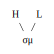

syl_tone_list: [2]
syl_mora_list: [1]
mora_tone_list: [2]
tone_mora_list: [1, 1]

🔹 Case 2


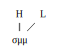

syl_tone_list: [2]
syl_mora_list: [2]
mora_tone_list: [1, 2]
tone_mora_list: [2, 1]


In [5]:
#matrice of inner structure

case1 = Autorep("","HL", assoc=[(1, 1, 1), (2, 1, 1)])
case2 = Autorep("","HL", assoc=[(1, 1, 1), (1, 2, 1), (2, 2, 1)])

print("🔹 Case 1")
case1.draw()
print("syl_tone_list:", case1.syl_tone_list())
print("syl_mora_list:", case1.syl_mora_list())
print("mora_tone_list:", case1.mora_tone_list())
print("tone_mora_list:", case1.tone_mora_list())

print("\n🔹 Case 2")
case2.draw()
print("syl_tone_list:", case2.syl_tone_list())
print("syl_mora_list:", case2.syl_mora_list())
print("mora_tone_list:", case2.mora_tone_list())
print("tone_mora_list:", case2.tone_mora_list())


In [8]:
low = Autorep("kà")
### lattice - patial order of the space 
def print_ar_tree(ar, depth=0, max_depth=3, root_assoc=None):
    if root_assoc is None:
        root_assoc = ar.assoc

    # ANSI colors by depth (cycle if needed)
    colors = [
        "\033[94m",  # Blue
        "\033[92m",  # Green
        "\033[93m",  # Yellow
        "\033[91m",  # Red
        "\033[95m",  # Magenta
        "\033[96m",  # Cyan
    ]
    reset = "\033[0m"
    color = colors[depth % len(colors)]
    indent = "  " * depth * 2

    # Show only new tuples
    new_tuples = [tup for tup in ar.assoc if tup not in root_assoc]

    node_label = f"D={depth}"
    if new_tuples:
        print(f"{indent}{color}* {node_label}  {ar.ocp_mel} {ar.assoc} {reset}")
    else:
        print(f"{indent}{color}- {node_label}  {ar.ocp_mel} {ar.assoc} {reset}")

    # Draw with tier labels
    # drawing = ar.draw()


    # Recurse
    if depth < max_depth - 1:
        for next_ar in ar.next_ar(2):
            print_ar_tree(next_ar, depth + 1, max_depth, root_assoc)
print_ar_tree(low,max_depth= 4)

- D=0  L [(1, 1, 1)] 
    * D=1  L [(1, 1, 1), (None, 1, 2)] 
        * D=2  L [(1, 1, 1), (None, 1, 2), (None, 1, 3)] 
            * D=3  L [(1, 1, 1), (None, 1, 2), (None, 1, 3), (None, 1, 4)] 
            * D=3  LH [(1, 1, 1), (2, None, None), (None, 1, 2), (None, 1, 3)] 
            * D=3  L [(1, 1, 1), (None, 1, 2), (None, 1, 3), (None, 2, 3)] 
            * D=3  L [(1, 1, 1), (1, 1, 2), (None, 1, 3)] 
        * D=2  LH [(1, 1, 1), (2, None, None), (None, 1, 2)] 
            * D=3  LH [(1, 1, 1), (2, None, None), (None, 1, 2), (None, 1, 3)] 
            * D=3  LHL [(1, 1, 1), (2, None, None), (3, None, None), (None, 1, 2)] 
            * D=3  LH [(1, 1, 1), (2, None, None), (None, 1, 2), (None, 2, 2)] 
            * D=3  LH [(1, 1, 1), (2, 1, 1), (None, 1, 2)] 
            * D=3  LH [(1, 1, 1), (1, 1, 2), (2, None, None)] 
            * D=3  LH [(1, 1, 1), (2, 1, 2)] 
        * D=2  L [(1, 1, 1), (None, 1, 2), (None, 2, 2)] 
            * D=3  L [(1, 1, 1), (None, 1, 2), (None, 2,

In [9]:
## at most 5 substructures will be generated

low_2 = Autorep("","LH", assoc=[(1, 1, 1),(2,None,None),(None,2,1),(3,None, None),(None,3,1)])
low_2.next_ar(2)

[LH, [(1, 1, 1), (2, None, None), (3, None, None), (None, 2, 1), (None, 3, 1), (None, 1, 2)],
 LHL, [(1, 1, 1), (2, None, None), (3, None, None), (4, None, None), (None, 2, 1), (None, 3, 1)],
 LH, [(1, 1, 1), (2, 1, 1), (3, None, None), (None, 2, 1), (None, 3, 1)],
 LH, [(1, 1, 1), (1, 2, 1), (2, None, None), (3, None, None), (None, 3, 1)],
 LH, [(1, 1, 1), (2, 2, 1), (3, None, None), (None, 3, 1)]]

In [10]:
## something about the HL pattern
intialHL = Autorep("", "HL", [(1, 1, 1), (2, 2, 1), (None,1,2)])
# check_from_data(intialHL,autolist,True)


middleHL = Autorep("", "LHL", [(1, 1, 1), (2, 1, 2), (3, 2, 2)])
check_from_data(middleHL,autolist,True)

HLH = Autorep("", "HLH", [(1, 1, 1), (2, 1, 2), (2, 2, 2), (3, None, None)])
check_from_data(HLH,autolist,True)

mù.tûm LHL, [(1, 1, 1), (2, 1, 2), (3, 2, 2)]
í.yàa.yée HLH, [(1, 1, 1), (2, 1, 2), (2, 2, 2), (3, 1, 3), (3, 2, 3)]


True